# Text classification using classic ML approach

In [1]:
import pandas as pd
import re
import gc
import warnings
import pickle

from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, auc, roc_curve, RocCurveDisplay
from sklearn.preprocessing import FunctionTransformer


import matplotlib.pyplot as plt

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category = ConvergenceWarning)

#### About Dataset

In [2]:
df = pd.read_csv(r'C:\Users\1NR_Operator_33\Desktop\imdb_dataset.csv')
df.sample(10)

,review,sentiment
43588,A variation of the same plot line was used in ...,positive
2153,"The promotions for ""Clubbed"" project a slick l...",negative
16608,TYSON <br /><br />Aspect ratio: 1.33:1<br /><b...,negative
31415,The Soap is an interesting movie and very bril...,positive
6261,Sad... really sad. This movie has nothing (hmm...,negative
5066,"I've seen this movie when I was young, and I r...",positive
36656,"In fact, the nature of the whole series is irr...",positive
34695,One of those films that I happened across thro...,positive
23081,I am a huge fan of Vonnegut's work and I'm ver...,positive
24958,Let me tell you a story.<br /><br />One day on...,negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [3]:
# The Count of classes 
print(f'Dataset dimensionality: {df.shape}')
print(f'The count of classes: {len(df["sentiment"].unique())}')

Dataset dimensionality: (50000, 2)
The count of classes: 2


In [4]:
df['sentiment'] = df['sentiment'].map({'negative': 0,'positive': 1})  # Label prep
df = df.rename(columns={'review':'text', 'sentiment': 'label'})  
df

,text,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [5]:
df = df.astype({'text': 'string', 'label': 'int8'})
df.dtypes

text     string[python]
label              int8
dtype: object

#### EDA

In [7]:
plt.style.use('seaborn-v0_8')
%matplotlib inline 

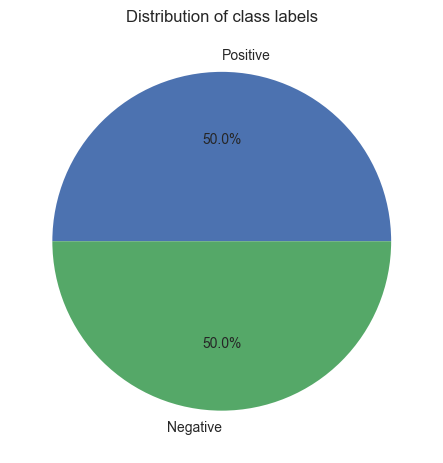

In [119]:


pie_data = df['label'].value_counts()
labels, values = pie_data.index, pie_data.values

fig, ax = plt.subplots()
ax.set(title='Distribution of class labels')
ax.pie(values, labels=['Positive', 'Negative'], autopct='%1.1f%%');

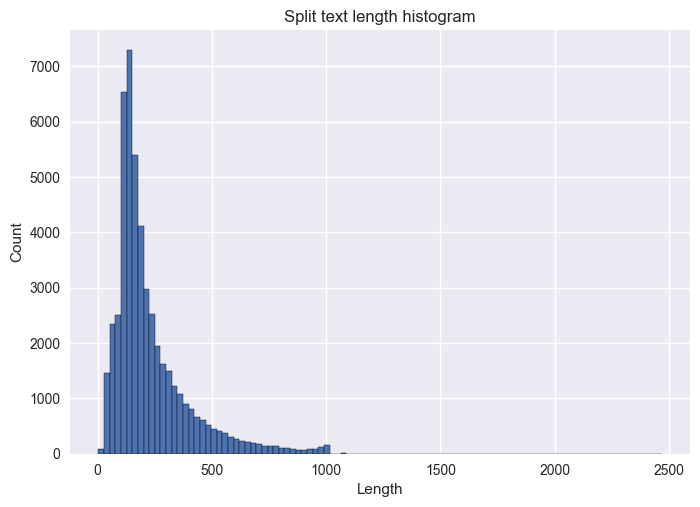

In [130]:


text_lens = [len(df['text'][i].split()) for i in range(len(df))]

fig, ax = plt.subplots()
ax.set(xlabel='Length', ylabel='Count', title='Split text length histogram')
ax.hist(text_lens, bins=100, ec='black');

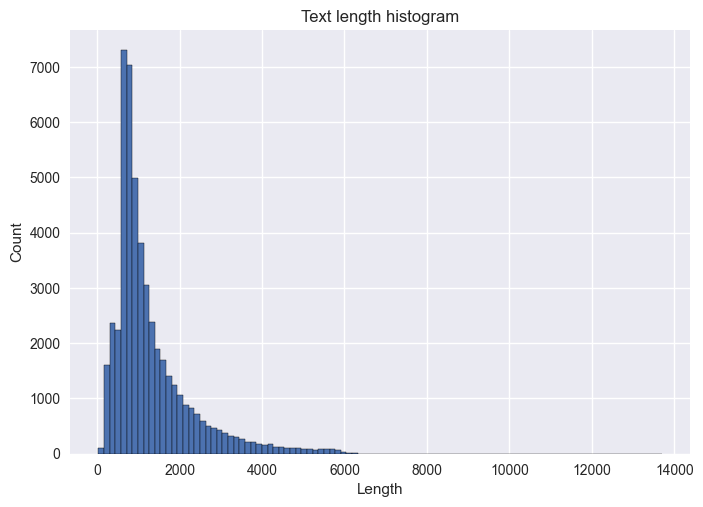

In [129]:


text_lens = [len(df['text'][i]) for i in range(len(df))]

fig, ax = plt.subplots()
ax.set(xlabel='Length', ylabel='Count', title='Text length histogram')
ax.hist(text_lens, bins=100, ec='black');

#### Text preprocessing

In [6]:
def symbols_remove(input_text: str) -> str:
    """Deleting all characters except words.
       The function starts with apply for the entire case"""
    
    link_process = re.sub(r"http://\S+|https://\S+", "", input_text)  # Links removing

    garbage_process = re.sub(r'([^\s\w])', '', link_process)  # Garbage removing

    word_process = re.sub(r'\w*\d+\w*', ' ', garbage_process)  # ОNLY WORDS

    output_text = re.sub('\s+', ' ', word_process).strip().lower()  # Space removing, register transfer

    return re.sub(r'\n', '', output_text)

In [7]:
stemmer = SnowballStemmer('english')              # For stemmer
STOP_WORDS_ENGLISH = stopwords.words('english')   # The block of stop-words

def text_preprocessing(input_text: str) -> str:
   """Tokenization, removal of stop words, spelling correction,
      Stemming, transfer from the list of tokens to str (for the vectorization stage)
      The function starts with apply for the entire corpus"""
   
   text_tokens = word_tokenize(input_text)                                               # Tokenization
   
   text_without_sw = [word for word in text_tokens if word not in STOP_WORDS_ENGLISH]    # Stop-words removing 

   text_with_stemming = [stemmer.stem(word) for word in text_without_sw]                 # Stemming

   output_text = ' '.join(text_with_stemming)
   
   return output_text

In [8]:
df['preprocess_text'] = df['text'].apply(symbols_remove)      # RegEx preprocessing
df['preprocess_text'] = df['preprocess_text'].apply(text_preprocessing)  # Tokenization, stop words, spelling, stemming, return to str

df_labels = df.pop('label') 
df.insert(2, 'label', df_labels) 
gc.collect()

7

In [9]:
df.sample(10)  # Let's look at result

,text,preprocess_text,label
16493,A lot of people in the cinema enjoyed this fil...,lot peopl cinema enjoy film made feel misanthr...,0
4018,At school I was taught how some shots were cal...,school taught shot call two director constant ...,1
8768,I wish they would just make a special section ...,wish would make special section video rental s...,0
44029,A tremendous action movie that I have ever see...,tremend action movi ever seen first express ut...,1
44354,Bedrooms and Hallways was one of the funniest ...,bedroom hallway one funniest film melbourn fil...,1
34849,Out of these Pokemon films (which are in order...,pokemon film order best least pokemon first mo...,1
14230,I saw this movie with some Indian friends on C...,saw movi indian friend christma day quick summ...,0
15821,I just attended a preview screening of this fi...,attend preview screen film masterpiec document...,0
4213,Fate puts a pair of priceless items in Ernest'...,fate put pair priceless item ernest hand get k...,1
6370,"The movie was excellent, save for some of the ...",movi excel save scene esposito enjoy brought t...,1


In [13]:
# Train & test split
RANDOM_STATE = 50
X_train, X_test, y_train, y_test = train_test_split(df['preprocess_text'], df['label'],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)

#### Model

In [14]:
text_pipeline = Pipeline([
                          ('vectorizer', TfidfVectorizer()), 
                          ('lr', LogisticRegression())
                         ])

In [15]:
# Grid parametrs
parametrs = {
              'vectorizer__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [5, 15, 50, 100],
            }

# CrossValidation into GridSearch
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Create grid search (+ CrossValidation in GridSearch)
grid_search = GridSearchCV(text_pipeline,
                           parametrs,
                           scoring='f1',
                           cv=kf,
                           verbose=1)

# Start
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=50, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [5, 15, 50, 100],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=1)

In [16]:
mean = grid_search.cv_results_['mean_test_score']  
std = grid_search.cv_results_['std_test_score']  
param = grid_search.cv_results_['params']  

grid_search_df = pd.DataFrame({'mean': mean, 'std': std, 'params': param})
grid_search_df.style.set_caption("Grid Search statistic data")

,mean,std,params
0,0.894181,0.003091,"{'lr__C': 5, 'vectorizer__ngram_range': (1, 1)}"
1,0.899497,0.003493,"{'lr__C': 5, 'vectorizer__ngram_range': (1, 2)}"
2,0.890553,0.001914,"{'lr__C': 15, 'vectorizer__ngram_range': (1, 1)}"
3,0.902319,0.002840,"{'lr__C': 15, 'vectorizer__ngram_range': (1, 2)}"
4,0.885599,0.002123,"{'lr__C': 50, 'vectorizer__ngram_range': (1, 1)}"
5,0.903825,0.002973,"{'lr__C': 50, 'vectorizer__ngram_range': (1, 2)}"
6,0.883967,0.001997,"{'lr__C': 100, 'vectorizer__ngram_range': (1, 1)}"
7,0.903953,0.002952,"{'lr__C': 100, 'vectorizer__ngram_range': (1, 2)}"


In [17]:
print(f'GRID SEARCH BEST SCORE: {grid_search.best_score_}')
print(f'GRID SEARCH BEST PARAMS: {grid_search.best_params_}')

GRID SEARCH BEST SCORE: 0.9039526367646047
GRID SEARCH BEST PARAMS: {'lr__C': 100, 'vectorizer__ngram_range': (1, 2)}


In [18]:
# Lets look the best Pipeline
best_pipeline = grid_search.best_estimator_

# Fit again for best pipeline 
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=100))])

#### Model evaluating

In [19]:
print(f"F1-SCORE ON TRAIN: {f1_score(y_train, best_pipeline.predict(X_train))}")
print(f"F1-SCORE ON TEST: {f1_score(y_test, best_pipeline.predict(X_test))}")

F1-SCORE ON TRAIN: 1.0
F1-SCORE ON TEST: 0.9024947818308319


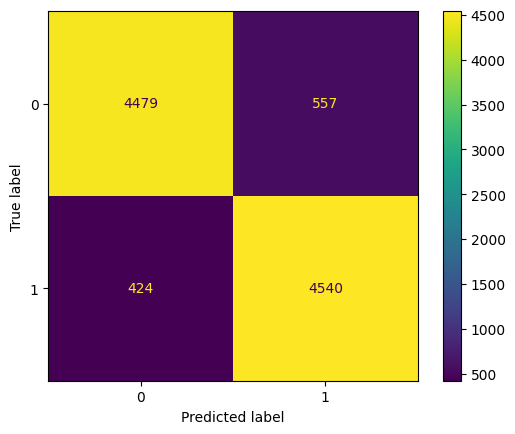

In [20]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, best_pipeline.predict(X_test)))
cm_display.plot()
plt.show()

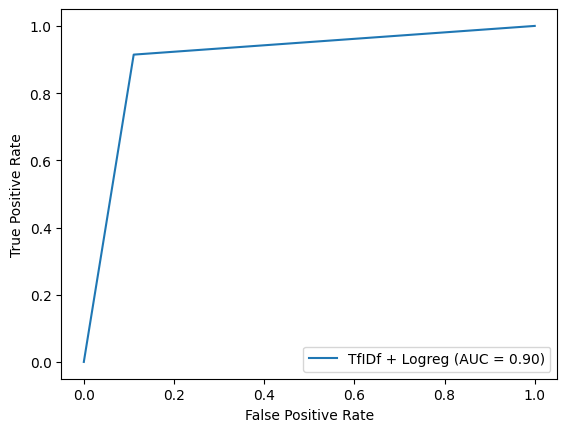

In [21]:
# Roc-auc score
fpr, tpr, thresholds = roc_curve(y_test, best_pipeline.predict(X_test))
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='TfIDf + Logreg')

display.plot()
plt.show()

In [58]:
def regex_text_preprocessing(texts: list[str]) ->list[str]:
    regex_prep = [symbols_remove(text) for text in texts]     # RegEx preprocessing
    return [text_preprocessing(text) for text in regex_prep]  # Text preprocessing


text_prep_transformer = FunctionTransformer(regex_text_preprocessing)

In [47]:
# Let's look at final pipeline
best_pipeline

Pipeline(steps=[['preprocessor',
                 FunctionTransformer(func=<function regex_text_preprocessing at 0x0000011802BFDB20>)],
                ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=100))])

In [140]:
# Evaluation on some texts
best_pipeline.predict(['Very awfull movie!',                                         # OK 
                       'This movie is so bad!',                                      # OK  
                       'I am very glad that i could see this movie! Excellent!',     # OK
                       'Very cool',                                                  # OK
                       'Nice movie, thank you sir',                                  # OK
                       'Not bad! I will review this movie',                          # Bad, because LogReg can't process the sequence
                       'I cant watch this movie'])                                   # OK                     

array([0, 0, 1, 1, 1, 0, 0], dtype=int8)

In [59]:
# Model saving

MODEL_SAVE_PATH = r"text_classification_models\log_reg_pipeline"

with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_pipeline, file)

# Text classification using RNN

In [10]:
from tensorflow import keras

from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras import backend as K

from keras.models import Sequential
from keras.layers import LSTM, GRU, LayerNormalization, BatchNormalization, Dropout, Embedding, Dense, Bidirectional

from  keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
from keras.activations import elu, relu

In [11]:
df

,text,preprocess_text,label
0,One of the other reviewers has mentioned that ...,one review mention watch oz episod youll hook ...,1
1,A wonderful little production. <br /><br />The...,wonder littl product br br film techniqu unass...,1
2,I thought this was a wonderful way to spend ti...,thought wonder way spend time hot summer weeke...,1
3,Basically there's a family where a little boy ...,basic there famili littl boy jake think there ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visual stun film...,1
...,...,...,...
49995,I thought this movie did a down right good job...,thought movi right good job wasnt creativ orig...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",bad plot bad dialogu bad act idiot direct anno...,0
49997,I am a Catholic taught in parochial elementary...,cathol taught parochi elementari school nun ta...,0
49998,I'm going to have to disagree with the previou...,im go disagre previous comment side maltin one...,0


In [81]:
# Hyperparameters 
max_words = 130000  # max number of words to use in the vocabulary
max_len = 300  # max length of each text (in terms of number of words)
embedding_dim = 300  # dimension of word embeddings

# Tokenize the texts and create a vocabulary
tokenizer = Tokenizer(num_words=max_words)

X_train, X_test, y_train, y_test = train_test_split(df['preprocess_text'],
                                                    df['label'], 
                                                    shuffle=True,
                                                    random_state=50)

tokenizer.fit_on_texts(X_train)  # Create vocabulary of words


train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences so they all have the same length (Now, we are working with X_train_seq, y_train |||| X_test_seq, y_test)
X_train_seq = pad_sequences(train_sequences, maxlen=max_len)
X_test_seq = pad_sequences(test_sequences, maxlen=max_len)

In [82]:
# Example of text sequence
X_train_seq[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [96]:
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, embedding_dim, input_length=max_len))

lstm_model.add(LSTM(32, return_sequences=True))
lstm_model.add(BatchNormalization())

lstm_model.add(LSTM(16, return_sequences=True))
lstm_model.add(LayerNormalization())

lstm_model.add(LSTM(8, return_sequences=False))

lstm_model.add(Dense(1, activation='sigmoid'))

In [97]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=6, verbose=1),  
    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=3, verbose=1, mode='auto')
]

In [98]:
lstm_model.compile(metrics=['accuracy'],
              loss='binary_crossentropy',
              optimizer=Adam())

In [99]:
history = lstm_model.fit(X_train_seq, y_train,
                    batch_size=128,
                    epochs=7,
                    validation_split=0.1,
                    callbacks=callbacks)

Epoch 1/7
264/264 [==============================] - 169s 621ms/step - loss: 0.3815 - accuracy: 0.8381 - val_loss: 0.2993 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 2/7
264/264 [==============================] - 161s 609ms/step - loss: 0.1717 - accuracy: 0.9409 - val_loss: 0.3112 - val_accuracy: 0.8757 - lr: 0.0010
Epoch 3/7
264/264 [==============================] - 157s 595ms/step - loss: 0.0834 - accuracy: 0.9751 - val_loss: 0.3669 - val_accuracy: 0.8755 - lr: 0.0010
Epoch 4/7
264/264 [==============================] - 154s 584ms/step - loss: 0.0619 - accuracy: 0.9823 - val_loss: 0.4218 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 5/7
264/264 [==============================] - 153s 580ms/step - loss: 0.0399 - accuracy: 0.9890 - val_loss: 0.4644 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 6/7
264/264 [==============================] - 165s 625ms/step - loss: 0.0559 - accuracy: 0.9826 - val_loss: 0.4838 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 7/7
264/264 [==============================] -

In [100]:
print(f'{lstm_model.name} accuracy: {lstm_model.evaluate(X_test_seq, y_test, verbose=False)[1]}')